# 1. Twitter Data

### The first step is to import the libraries required for twitter scraping and data manipulation 

In [1]:
import json
import time
import twitter
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',10)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
import textblob

[nltk_data] Downloading package punkt to /Users/vasusingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vasusingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Setting up the authorization : Twitter APIs handle enormous amounts of data. The way this data is secured for developers and users alike is through authentication.

In [2]:
# To set up your Twitter app and get your secret key, refer to the README
# Enter your credentials below

consumer_key = ''
consumer_secret = ''
access_key= ''
access_secret = ''

# Authorization
twitter_api = twitter.Api(consumer_key = consumer_key,
                              consumer_secret = consumer_secret,
                              access_token_key = access_key,
                              access_token_secret= access_secret,
                              tweet_mode='extended') # extended mode for scraping the full text from tweets

### Scraping Tweets with a search keyword

In [12]:
def getmultipleData(search_keyword,no): # search_keyword -> topic to search tweets, no -> number of tweets
    
    count = 20 # count -> number of tweets to scrape in one request.Try to keep less to avoid duplicates.
    lowest_id = 0
    
    with open('Tweets'+ search_term + str('.json'),'a') as outfile: # opening json file to save the data
        
        time.sleep(5)
        results = twitter_api.GetSearch(term = search_keyword, count = count,lang = 'en')
        
        for tweet in results:
            tweet = str(tweet).replace('\n',' ').replace('\r',' ') # remove new lines
            tweet = (json.loads(tweet))
            lowest_id = tweet['id'] # keep track of lowest tweet on the current page
            json.dump(tweet,outfile)
            outfile.write('\n') #print tweets on new lines
            
        for i in range(0,(no-count)//count):
            
            time.sleep(5)
            results = twitter_api.GetSearch(term = search_keyword, count = count, max_id = lowest_id-1,lang = 'en')
            
            for tweet in results:
                tweet = str(tweet).replace('\n',' ').replace('\r',' ') # remove new lines
                tweet = (json.loads(tweet))
                lowest_id = tweet['id'] # keep track of lowest tweet on the current page
                json.dump(tweet,outfile)
                outfile.write('\n') #print tweets on new lines

                
# input for keyword and number of tweets                                
search_term = input('Enter Your Search Term : ')
no_of_tweets = int(input('How many Tweets Do you want ? : '))

print('Fetching Tweets : >>')
getmultipleData(search_term,no_of_tweets)
print('Done -->')


data = [json.loads(line) for line in open('Tweets'+ search_term + str('.json'), 'r')]

list_tweets = []

for i in range(len(data)):
    try: 
        list_tweets.append(data[i]['retweeted_status']['full_text'])    
    except:
        list_tweets.append(data[i]['full_text'])   
        
list_tweets = set(list_tweets) # Removing any duplicate/retweeted tweets

# final dataframe consisting of scraped tweets
final_df = pd.DataFrame(data = list_tweets,columns=['Tweet'])

Enter Your Search Term : US Elections
How many Tweets Do you want ? : 1300
Fetching Tweets : >>
Done -->


In [3]:
## To get the data which is already scraped
search_term = ''
data = [json.loads(line) for line in open('Tweets'+ search_term + str('.json'), 'r')]

list_tweets = []

for i in range(len(data)):
    try: 
        list_tweets.append(data[i]['retweeted_status']['full_text'])    
    except:
        list_tweets.append(data[i]['full_text'])   
        
list_tweets = set(list_tweets) # Removing any duplicate/retweeted tweets

# final dataframe consisting of scraped tweets
final_df = pd.DataFrame(data = list_tweets,columns=['Tweet'])

### Additional : It is also possible to scrape the tweets from users of choice. For this analysis we will stick to our previously scraped data

In [ ]:
## Getting Twitter Data from a Particular User

twitter_handles = ['PlattsOil','IEA','markets','IHSMarkit','EIAgov','WorldOil','OGJOnline','OPECSecretariat','OPIS',
                   'ftenergy','ETEnergyNews','ESAIEnergy','RefinitivEnergy','BloombergNRG']


twitter_people = ['realDonaldTrump','IEABirol','JZarif','SecPompeo','aeberman12']
    
def getuserdata(user_name):
    
    results = twitter_api.GetUserTimeline(screen_name = user_name,count = 600,include_rts = False,exclude_replies=True)
    l =  [{'Text':status.full_text,'Fav-Count':status.favorite_count,'Retweet-Count':status.retweet_count} for status in results]
    user_tweets = []
    for i in range(len(results)):
        
        user_tweets.append(l[i]['Text'])
    
    return user_tweets

choice = int(input('Enter Your Choice (1(Twitter Accounts) or 2(Important People Accounts)) : '))
print('Fetching Twitter Data -->')

if choice == 1:
    
    for i in twitter_handles:
    
        
        user_tweets = getuserdata(i)
        spec_df = pd.DataFrame(data = user_tweets,columns=['Tweet'])
        # Saving The Tweets
        writer = pd.ExcelWriter('Tweets_ '+ i +str('.xlsx'))
        # write dataframe to excel
        spec_df.to_excel(writer)
        # save the excel
        writer.save()
    
elif choice == 2:
    
    for i in twitter_people:
    
        
        user_tweets = getuserdata(i)
        spec_df = pd.DataFrame(data = user_tweets,columns=['Tweet'])
        # Saving The Tweets
        writer = pd.ExcelWriter('Tweets_ '+ i +str('.xlsx'))
        # write dataframe to excel
        spec_df.to_excel(writer)
        # save the excel
        writer.save()
    

### Scraped Tweets:

In [13]:
final_df

,Tweet
0,Introducing Proportional Representation into t...
1,Harris echoing Biden's message – the idea that...
2,Thread. No surprise to anyone paying attention...
3,"‘You’re entitled to your own opinion, you’re n..."
4,"‘You’re entitled to your own opinion, you’re n..."
...,...
500,"Swear to god, Americans thinking that polls ar..."
501,"The American people, through their current ins..."
502,Harris and Pence Clash on Climate Change https...
503,"""The future is bright...We fight for each pers..."


# 2. Building WordCloud

### Clean Tweets and Visualize frequent words

In [14]:
class PreProcessTweets:
    def __init__(self):
        self._stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL','rt','amp']) # to remove the stopwords

    def processTweets(self, list_of_tweets):
        processedTweets=[]
        for tweet in list_of_tweets:
            processedTweets.append((self._processTweet(tweet)))
            
        l = []
        for items in processedTweets:
            l.append(' '.join(items))
            
        df = pd.DataFrame(l,columns=['ProcessedTweets'])
        return df
    
    def _processTweet(self, tweet):
        tweet = tweet.lower() # convert text to lower-case
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
        tweet = re.sub(r'#([^\s]+)', '', tweet) # remove the # in #hashtag
        tweet = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
        return [word for word in tweet if word not in self._stopwords]

## Pre-Processing Our Tweets
tweetProcessor = PreProcessTweets()
cleaned_tweets = tweetProcessor.processTweets(final_df.Tweet)

In [15]:
cleaned_tweets

,ProcessedTweets
0,introducing proportional representation uk wou...
1,harris echoing biden 's message – idea america...
2,thread surprise anyone paying attention uk con...
3,‘ ’ entitled opinion ’ entitled facts ’ pence ...
4,‘ ’ entitled opinion ’ entitled facts ’ pence ...
...,...
500,swear god americans thinking polls going repre...
501,american people current institutions like nonp...
502,harris pence clash climate change
503,`` future bright ... fight person vote '' -- k...


Building The WordCloud : >>


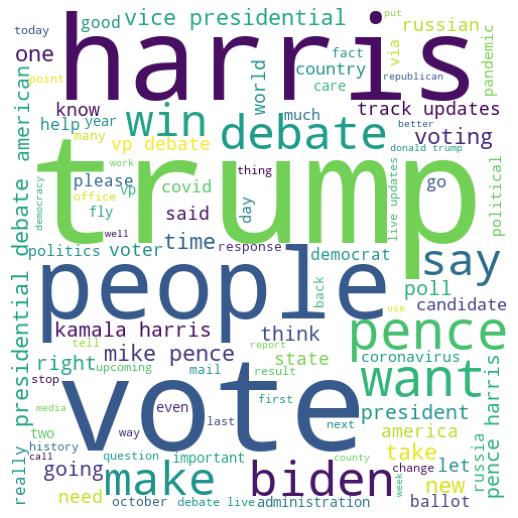

In [25]:
## Remember To clean The Tweets before for better results
def buildwordcloud(df,search_term):
    import wordcloud
    comment_words = ' '
    stopwords = set(wordcloud.STOPWORDS)# using stopwords included in wordcloud library
    stopwords = list(stopwords) + ['AT_USER','URL','rt','amp',"n't"] + search_term.split() + ['election'] # adding our own stopwords
    for val in df['ProcessedTweets']:
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        for word in tokens:
            comment_words = comment_words + word + ' '
    wordcloud = wordcloud.WordCloud(width=500,height=500,max_words = 100,background_color='white',stopwords=stopwords,min_font_size=10).generate(comment_words)

    # plot the wordcloud image
    plt.figure(figsize=(7,7),facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

print('Building The WordCloud : >>')
buildwordcloud(cleaned_tweets,search_term)

In [29]:
# Tokenize
import gensim

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True))
        
data_words = list(sent_to_words(final_df['Tweet']))
print(data_words[:1])

[['introducing', 'proportional', 'representation', 'into', 'the', 'uk', 'would', 'make', 'us', 'an', 'actual', 'democracy', 'elections', 'would', 'be', 'meaningful', 'and', 'attract', 'voters', 'which', 'would', 'increase', 'voter', 'turnout', 'seriously', 'who', 'doesn', 'want', 'this']]


In [48]:
# Lemmatization
import spacy

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

# python -m spacy download en_core_web_sm
# python -m spacy download en

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['introduce proportional representation would make actual democracy election would meaningful attract voter would increase voter turnout seriously doesn want', 'echo biden message idea stand world diminish trump biden want restore american leadership world track live update vpdebate here']


In [52]:
# Word-Document Matrix

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum number occurences of a word required
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num of characters > 3
                            
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [54]:
# Build LDA model with Sklearn

lda_model = LDA(n_components=15,               # Number of topics
                max_iter=10,                   # Max learning iterations
                learning_method='online',   
                random_state=100,              # Random state
                batch_size=32)                # n docs in each learning iter
                                            
                                      
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model) # Model attributes

LatentDirichletAllocation(batch_size=32, learning_method='online',
                          n_components=15, random_state=100)


In [55]:
#Evaluate model quality

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp((-1) * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))


Log Likelihood:  -11407.180137307756
Perplexity:  94.30221122759222


In [56]:
import pyLDAvis
import pyLDAvis.sklearn

#Visualize with pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model,data_vectorized,vectorizer,mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8      114.344879  114.308296       1        1  12.554477
7      105.821045  -93.749626       2        1   9.319987
1     -138.334473   95.320763       3        1   9.306581
6       -7.436697  111.259697       4        1   9.107952
13    -207.550629 -105.472603       5        1   8.767596
9       52.817650   14.603765       6        1   7.041051
0      168.010849    6.806950       7        1   6.857796
5      -94.169601 -157.789551       8        1   6.811162
3     -122.849174  -39.059418       9        1   6.217599
11     -94.894264  195.408295      10        1   5.930179
4       24.927401 -180.464874      11        1   5.772199
2      -53.413467   26.832108      12        1   5.382582
14     -12.255850  -72.093201      13        1   4.856037
12    -224.217957   28.070581      14        1   1.037400
10      36.154255  209.427582      15        1   1.037400, topic_info=        Term        Freq       Total Category  logprob  loglift
83      vote   80.000000   80.000000  Default  30.0000  30.0000
15    debate  106.000000  106.000000  Default  29.0000  29.0000
25     https  105.000000  105.000000  Default  28.0000  28.0000
16  election  360.000000  360.000000  Default  27.0000  27.0000
90       win   50.000000   50.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
45    people    0.276927   48.132878  Topic15  -4.5432  -0.5895
87      want    0.276927   40.746364  Topic15  -4.5432  -0.4229
35      lose    0.276926   22.242311  Topic15  -4.5432   0.1825
25     https    0.276923  105.800729  Topic15  -4.5432  -1.3771
58    really    0.276920   17.162851  Topic15  -4.5432   0.4417

[719 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0         4  0.893948  administration
1        10  0.954983        american
2         9  0.957560             amp
3         1  0.277779             ask
3         4  0.648151             ask
...     ...       ...             ...
90        7  0.980614             win
91        9  0.880950            work
92        2  0.808397           world
92       10  0.146981           world
93        3  0.868710            year

[153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 2, 7, 14, 10, 1, 6, 4, 12, 5, 3, 15, 13, 11])

# 3.Topic Modelling

### Automatically extract what topics people are discussing from large volumes of text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA,TruncatedSVD


In [27]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles to give a DTM
count_data = count_vectorizer.fit_transform(cleaned_tweets['ProcessedTweets'])

import warnings
warnings.simplefilter('ignore',DeprecationWarning)

def print_topics(model,count_vectorizer,n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx,topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Tweak the two parameters below

number_topics = 7
number_words = 5

# Create and fit the LDA model

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model

print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
elections trump vote election pence

Topic #1:
elections win debate presidential vote

Topic #2:
harris pence elections debate trump

Topic #3:
elections trump america vote entitled

Topic #4:
debate pence harris elections trump

Topic #5:
elections people trump want says

Topic #6:
elections trump know let think


###### Note : The above results can be improved by using n-grams

# 4. Sentiment Score

### Sentiment analysis helps us identify emotions through social media texts

In [37]:
def senti(x):
    return textblob.TextBlob(x).sentiment.polarity

d1 = pd.DataFrame()
d1['Tweet'] = final_df['Tweet']
d1['Sentiment-Polarity'] = final_df['Tweet'].apply(senti)

avg_score = np.average(d1['Sentiment-Polarity'])
print('Average Polarity Score : ' +str(round(avg_score,3)))

Average Polarity Score : 0.046


In [88]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    l = []
    score = analyser.polarity_scores(sentence)
    l.append(score)
    return l
    
d1['vaderScore'] = final_df['Tweet'].apply(lambda x: sentiment_analyzer_scores(x))

d1['vaderScore'] = d1['vaderScore'][0][0]['compound']

avg_score = np.average(d1['vaderScore'])
print('Average vader Score : ' +str(round(avg_score,3)))

Average vader Score : -0.79
